The Customer Churn Prediction Model is a machine learning-based solution designed to identify customers at high risk of terminating their relationship with a company. By analyzing historical data and behavioral patterns, this model provides businesses with valuable insights to proactively engage with customers, improve retention rates, and reduce revenue loss. in this model i use Gradient Boosting and Random forest classifer as models for predictions.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
import scipy
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from collections import Counter
from imblearn.combine import SMOTEENN
plt.style.use('default')
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('customer_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# Dropping unecessary columns
df.drop('customerID', axis = 1, inplace = True)

In [10]:
# converting numerical columns with object dtype to numerical dtype
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

EDA EXPLORATIVE DATA ANALYSIS

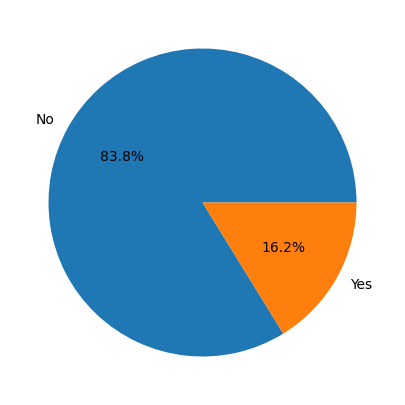

In [11]:
plt.figure(figsize = (10,5))
plt.pie(df['SeniorCitizen'].value_counts(), autopct = '%.1f%%', labels = ['No', 'Yes'])
plt.show()

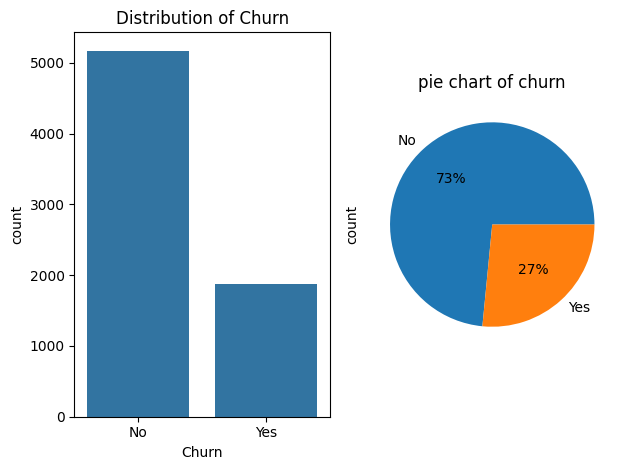

In [12]:
# check the distribution of the churn class
plt.subplot(121)
sns.countplot(data = df, x = 'Churn')
plt.title('Distribution of Churn')

plt.subplot(122)
df['Churn'].value_counts().plot(kind = 'pie', autopct = '%1.f%%', labels = ['No','Yes'])
plt.title('pie chart of churn')
plt.tight_layout()
plt.show()

In [13]:
# how much loss we are having because of customer churn
churn_customers = df[df['Churn'] == 'Yes']
loss = churn_customers['TotalCharges'].sum()
total_revenue = df['TotalCharges'].sum()
print('We have lost around {}$ due to customer churn'.format(loss))
#print('We have lost around {} percentage of revenue due to customer churn'.format(np.round(loss/total_revenue*100, decimals = 2)))
print('We have lost around {} percentage of revenue due to customer churn'.format(np.round(loss/total_revenue*100, decimals = 2)))

We have lost around 2862926.9$ due to customer churn
We have lost around 17.83 percentage of revenue due to customer churn


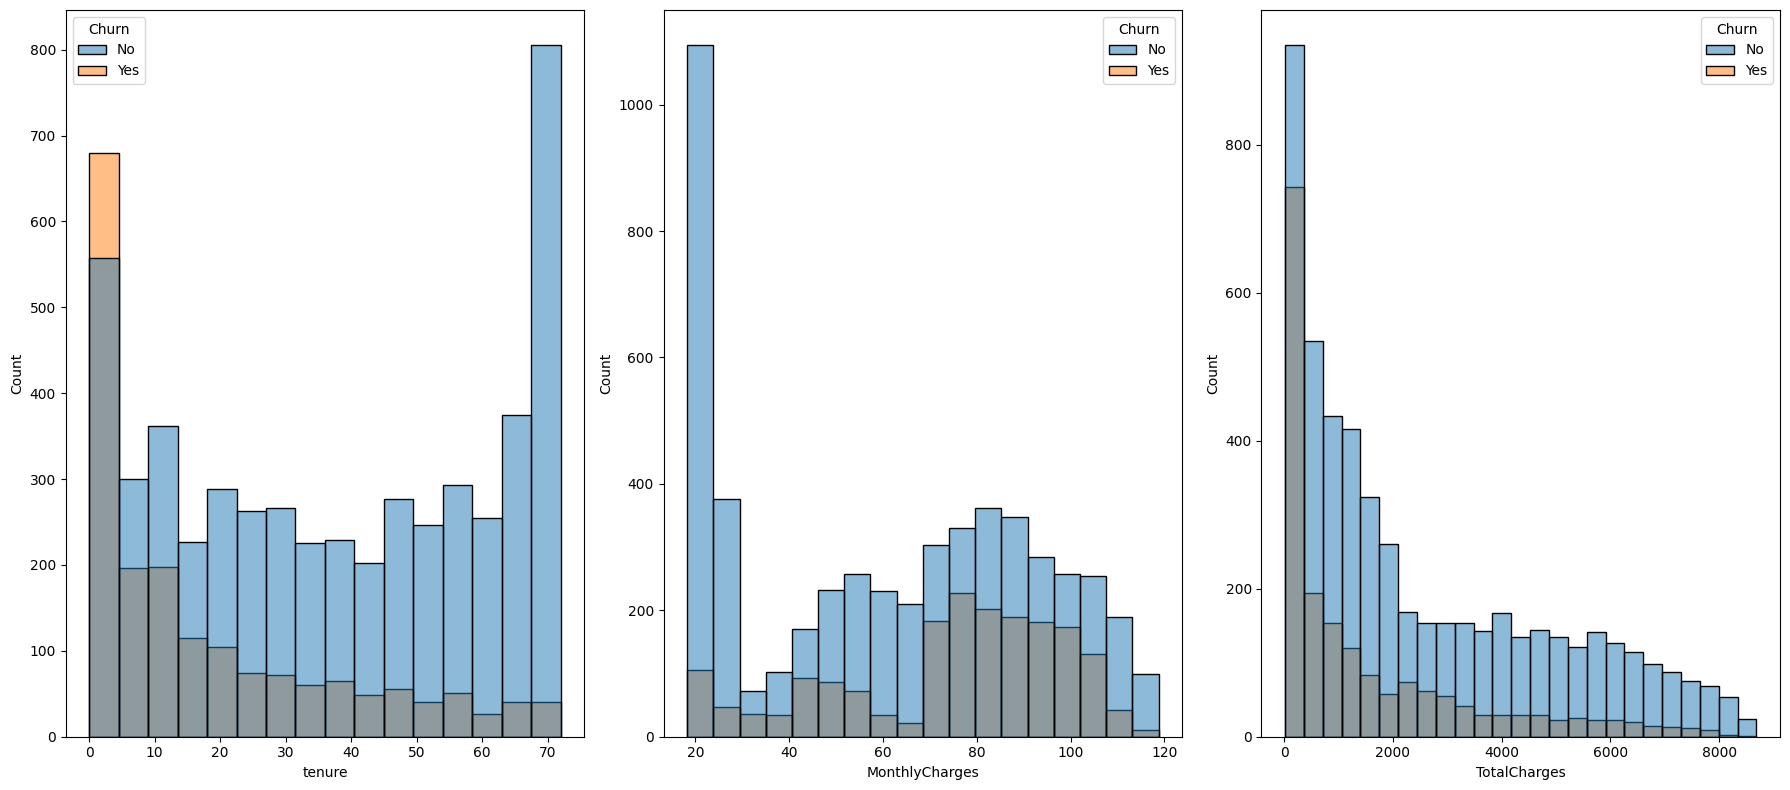

In [14]:
# plot numerical variables with histogram
fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18,8))
axes = axs.flatten()
num_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

for i, col in enumerate(num_columns):
    if(col!='SeniorCitizen'):
        sns.histplot(x = col, data = df, hue  = 'Churn', ax = axes[i])
fig.tight_layout()
plt.show()

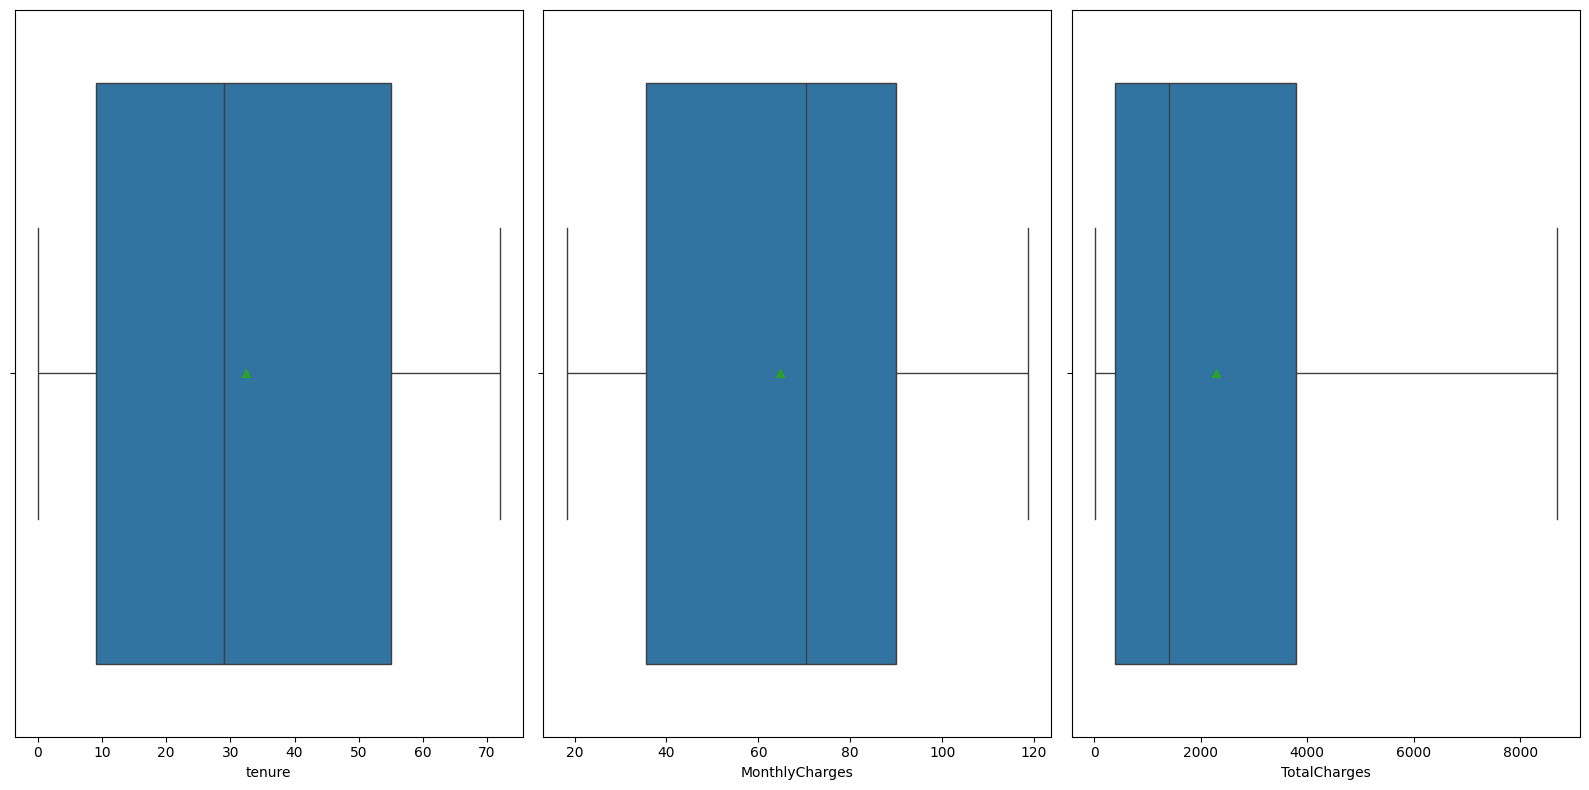

In [15]:
# checking for outliers in the dataset
fig,axs = plt.subplots(nrows =1, ncols = 3, figsize = (16,8))
axes = axs.flatten()
num_columns = ['tenure', 'MonthlyCharges','TotalCharges']
for i,col in enumerate(num_columns):
    if(col!= 'SeniorCitizen'):
        sns.boxplot(x = col, data = df, showmeans = True, ax = axes[i])
fig.tight_layout()
plt.show()




UNIVARIATE ANALYSIS

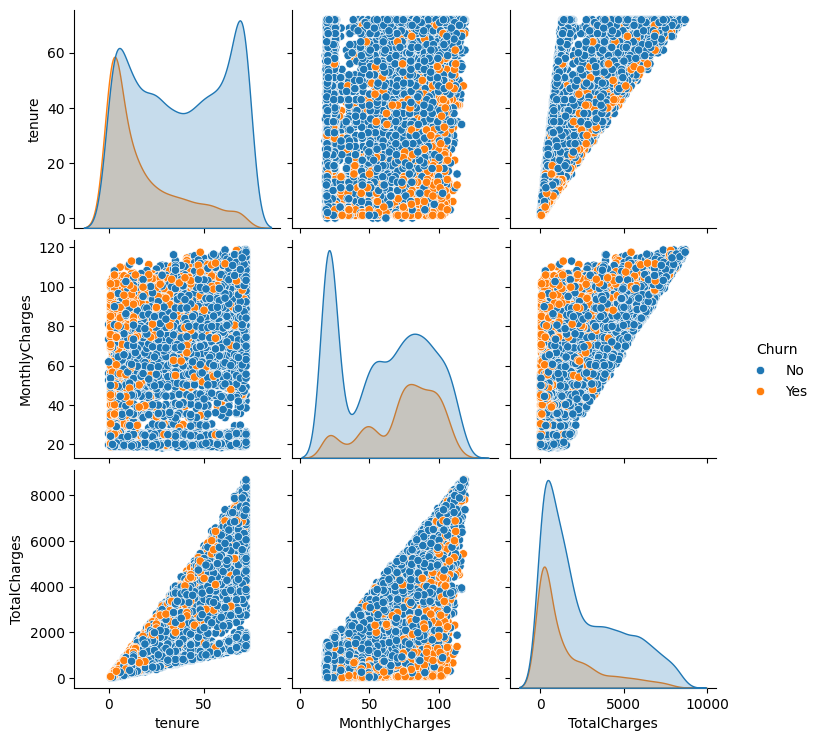

In [16]:
sns.pairplot(df.drop(columns = 'SeniorCitizen'), hue = 'Churn', kind = 'scatter')
plt.show()

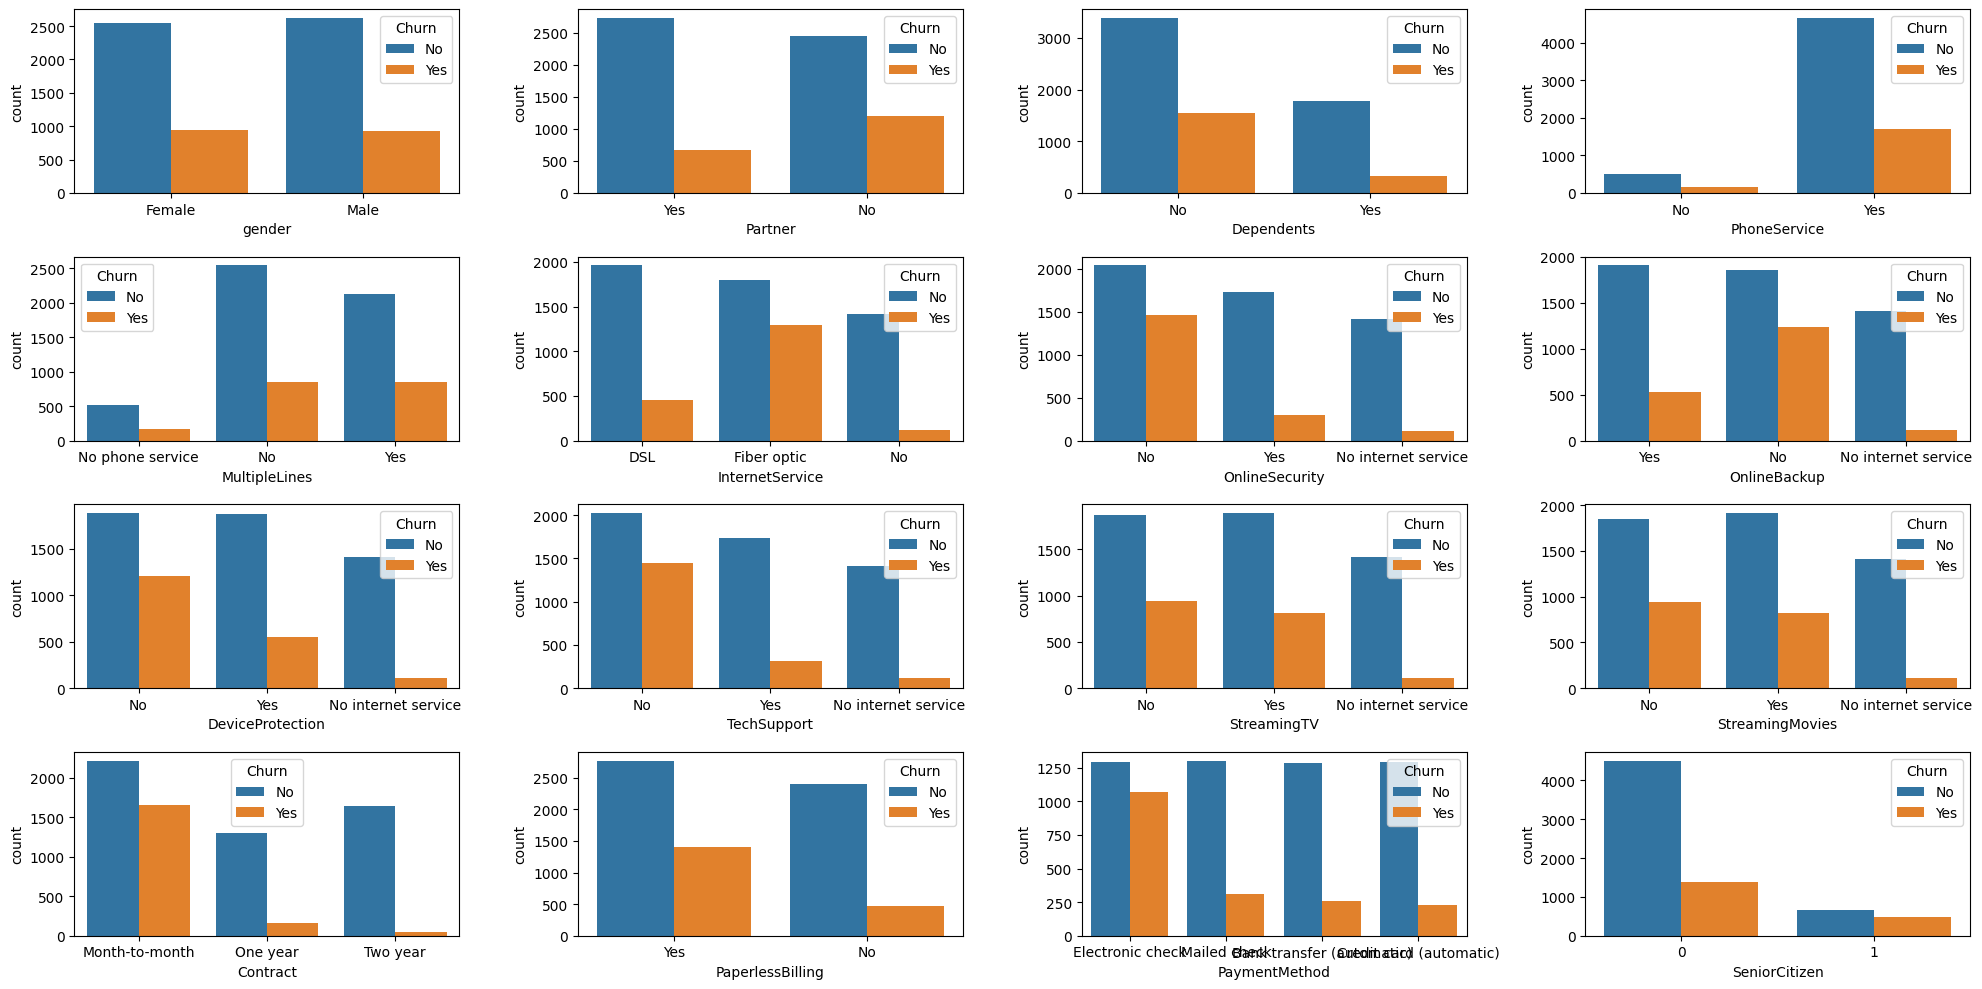

In [17]:
# plot categorical features:
cat_features = list(df.select_dtypes(include = 'object').columns)
cat_features.remove('Churn')
cat_features.append('SeniorCitizen')

fig,axs = plt.subplots(nrows = 4, ncols =  4, figsize = (20,10))
axes = axs.flatten()
for i, col in enumerate(cat_features):
    sns.countplot(x = col, hue = 'Churn', data = df, ax = axes[i])

fig.tight_layout()
plt.show()

DATA CLEANING


In [18]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [19]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [20]:
# Encoding of categorical variables using label encoder
encoder = LabelEncoder()
for feature in df.select_dtypes(include = 'object').columns:
    df[feature] = encoder.fit_transform(df[feature])

In [21]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [22]:
df.shape

(7043, 20)

In [23]:
df.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

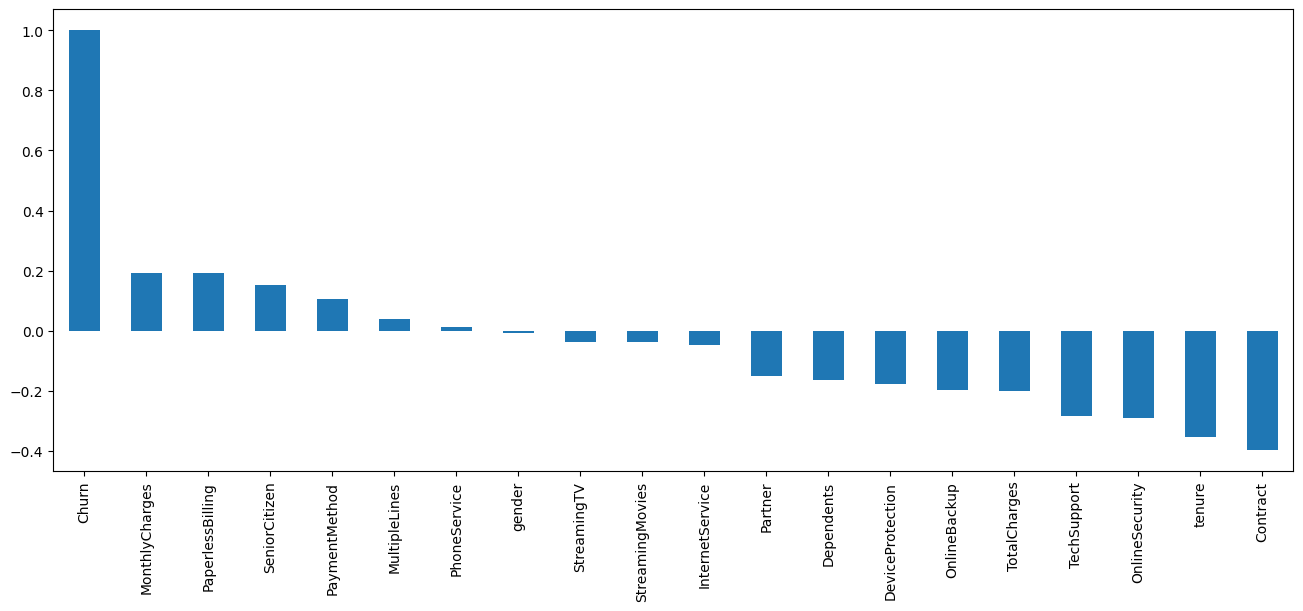

In [24]:
# get correlation of the target variables(churn) with other varibales
plt.figure(figsize = (16,6))
df.corr()['Churn'].sort_values(ascending = False).plot(kind ='bar')
plt.show()

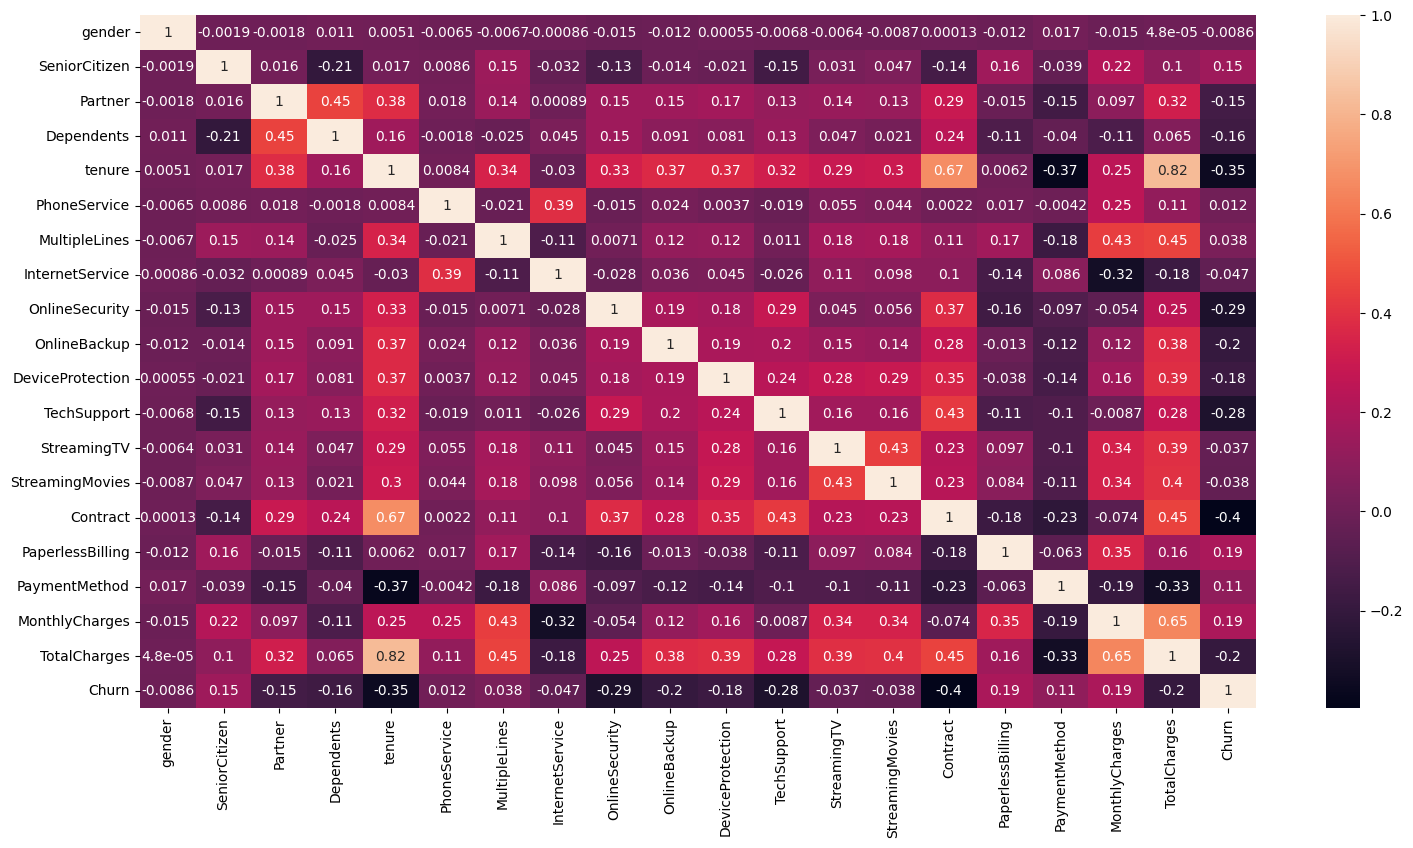

In [25]:
# using heatmap to check correlation
plt.figure(figsize = (18,9))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [26]:
x = df.drop('Churn', axis = 1)
y = df['Churn']

** FEATURE SELECTION**

In [27]:
# selecting only 10 features that has higher correlation with Churn
select_feature = SelectKBest(k = 10)
select_feature.fit(x,y)

SelectKBest()

In [28]:
# 10 highly correlated features
select_feature.get_feature_names_out()

array(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

In [29]:
# Handling of imbalance dataset
smote = SMOTEENN()
x_st,y_st = smote.fit_resample(x,y)

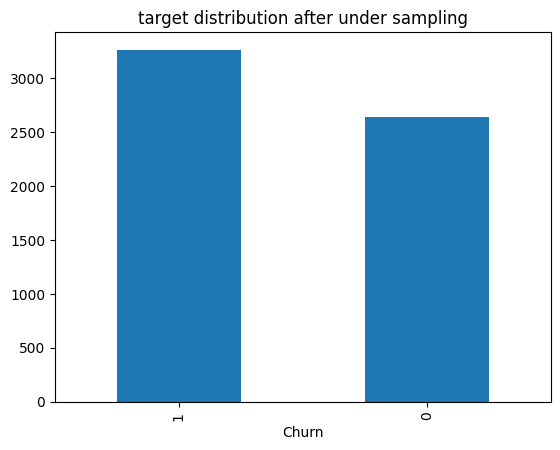

In [30]:
y_st.value_counts().plot(kind = 'bar')
plt.title('target distribution after under sampling')
plt.show()

In [31]:
# Spliting of training and test dataset in the ratio of 80:20
x_train,x_test,y_train,y_test = train_test_split(x_st,y_st, test_size = 0.2, random_state = 42)

In [32]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4721, 19), (4721,), (1181, 19), (1181,))

Model Building and performing hyperparameter tunning using RandomSearchCV

In [33]:
def evaluate_model_performance(model,test_data):
  prediction = model.predict(test_data)
  print('Validation Accuracy :{:.2f} %'.format(accuracy_score(y_test,prediction)))
  print('Precision Score :{:.2f} %'.format(precision_score(y_test,prediction)))
  print('Recall Score :{:.2f} %'.format(recall_score(y_test,prediction)))
  print('F1 score :{:.2f} %'.format(f1_score(y_test,prediction)))
  print(classification_report(y_test,prediction))


In [34]:
param_grid = {'n_estimators':[40,80,120,160,200],
              'max_depth': [2,4,6,8,10],
              'criterion':['gini'],
              'random_state':[27,42,43]
              }
random_search_cv = RandomizedSearchCV(estimator = RandomForestClassifier(),
                                      param_distributions = param_grid, n_iter = 12, cv = 5, scoring = 'accuracy')
random_search_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=12,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'n_estimators': [40, 80, 120, 160, 200],
                                        'random_state': [27, 42, 43]},
                   scoring='accuracy')

In [35]:
param_grid = {
    'n_estimators': [40, 80, 120, 160, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'criterion': ['gini'],
    'random_state': [27, 42, 43]
}

random_search_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=12,
    cv=5,
    scoring='accuracy'
)

random_search_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=12,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'n_estimators': [40, 80, 120, 160, 200],
                                        'random_state': [27, 42, 43]},
                   scoring='accuracy')

In [36]:
random_search_cv.best_params_

{'random_state': 27, 'n_estimators': 40, 'max_depth': 10, 'criterion': 'gini'}

In [37]:
# get final model with best param from RandomizedSearchCV
rf_final_model = random_search_cv.best_estimator_

In [38]:
# evaluate Random Forest Classifier
evaluate_model_performance(rf_final_model,x_test)

Validation Accuracy :0.95 %
Precision Score :0.96 %
Recall Score :0.95 %
F1 score :0.95 %
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       542
           1       0.96      0.95      0.95       639

    accuracy                           0.95      1181
   macro avg       0.95      0.95      0.95      1181
weighted avg       0.95      0.95      0.95      1181



In [39]:
param_grid2 = {
    'n_estimators': [100, 150, 200, 300],
    'criterion': ['friednan_mse', 'squared_error', 'mse', 'mae'],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'loss':['deviance','exponential']
}

In [40]:
random_search_cv2 = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                                       param_distributions=param_grid2)
random_search_cv2.fit(x_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'criterion': ['friednan_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [2, 4, 6, 8],
                                        'n_estimators': [100, 150, 200, 300]})

In [41]:
random_search_cv2.best_params_

{'n_estimators': 300,
 'max_depth': 4,
 'loss': 'exponential',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

In [42]:
gb_final_model = random_search_cv2.best_estimator_

In [43]:
evaluate_model_performance(gb_final_model, x_test)

Validation Accuracy :0.95 %
Precision Score :0.96 %
Recall Score :0.95 %
F1 score :0.95 %
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       542
           1       0.96      0.95      0.95       639

    accuracy                           0.95      1181
   macro avg       0.95      0.95      0.95      1181
weighted avg       0.95      0.95      0.95      1181



**Save Final Model Integration with Application**


In [44]:
#file = open('trained_model.pkl','wb')
#pickle.dump(rf_final_model,file)
#file.close

In [45]:
# making a predictive system
input_data = (1,	0,	0,	0,	45,	0,	1,	0,	2,	0,	2,	2,	0,	0,	1,	0,	0,	42.30,	1840.75)
 #(0, 0, 1, 0, 1,	0,	1,	0,	0,	2,	0,	0,	0,	0,	0,	1,	2,	29.85, 29.85)
 #(1, 0, 0, 0,	34,	1,	0,	0,	2,	0,	2,	0,	0,	0,	1,	0,	3,	56.95,	1889.50)
 #(0, 0, 1, 0, 1,	0,	1,	0,	0,	2,	0,	0,	0,	0,	0,	1,	2,	29.85, 29.85)


# changing the input data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

prediction = rf_final_model.predict(input_data_reshaped)
print(prediction)

if(prediction[0] == 0):
    print('This Customer will not Churn(False(0))')
else:
    print('This customer will Churn(True(1))')

[0]
This Customer will not Churn(False(0))


In [46]:
filename = 'trained_model.sav'
pickle.dump(rf_final_model, open(filename, 'wb'))

In [47]:
# loadind the saved model
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

In [48]:
import sklearn
print(sklearn.__version__)


1.2.2
